# Week 7: Transformers and Doc Embeddings

Additional references:
- [Character Level Language Model (GPU required)](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Character_Level_Language_Model_rendered.ipynb)
- [Transformers (BERT fine-tuning): Joint Intent Classification and Slot Filling](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Transformers_Joint_Intent_Classification_Slot_Filling_rendered.ipynb)
- [Generating Language with huggingface](https://huggingface.co/blog/how-to-generate)
- [huggingface examples](https://huggingface.co/transformers/quickstart.html)

In [1]:
from google.colab import files
uploaded_1 = files.upload()

Saving sc_cases_cleaned.pkl to sc_cases_cleaned.pkl


In [2]:
#setup
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

df = pd.read_pickle('sc_cases_cleaned.pkl', compression='gzip')
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 819
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   case_name       768 non-null    object        
 1   opinion_type    768 non-null    object        
 2   date_standard   768 non-null    datetime64[ns]
 3   authorship      768 non-null    object        
 4   x_republican    768 non-null    float64       
 5   maj_judges      768 non-null    object        
 6   dissent_judges  768 non-null    object        
 7   topic_id        768 non-null    float64       
 8   cite_count      768 non-null    float64       
 9   opinion_text    768 non-null    object        
 10  year            768 non-null    int64         
 11  log_cite_count  768 non-null    float64       
 12  author_id       768 non-null    int8          
dtypes: datetime64[ns](1), float64(4), int64(1), int8(1), object(6)
memory usage: 78.8+ KB


# Huggingface Transformer

In [3]:
#!pip install transformers
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# gpu or cpu?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


Load the model from a pretrained checkpoint.

In [4]:
model_name = 'distilbert-base-uncased' # huggingface model_ID or path to folder
model = DistilBertForSequenceClassification.from_pretrained(model_name)
print (model)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
inputs = tokenizer(df.iloc[0]['opinion_text'], return_tensors="pt")
print(inputs)

#[32, 100, 23, 0, 0, 0, 0, 0] -> [1, 1, 1, 0, 0, 0, 0, 0]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4669 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[  101,  3425, 18353,  ...,  3641,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}


In [6]:
inputs = tokenizer(df['opinion_text'].tolist(), return_tensors="pt", padding=True, truncation=True)
labels = torch.tensor(df['x_republican'].tolist()).long()
print(inputs, labels)

{'input_ids': tensor([[  101,  3425, 18353,  ...,  6525,  3089,   102],
        [  101,  3425,  8799,  ...,  4781,  2580,   102],
        [  101,  3425,  1051,  ..., 13931,  9964,   102],
        ...,
        [  101,  3425,  8040,  ...,  2005,  1996,   102],
        [  101,  3425,  2726,  ...,  2015,  2006,   102],
        [  101,  3425,  1051,  ..., 25394, 11461,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])} tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

More infos about huggingface tokenizers can be found [here](https://huggingface.co/transformers/main_classes/tokenizer.html).

Now we have a set of text inputs and authors indicators as labels and we can train a transformers model using a cross-entropy loss function

In [7]:
unique_labels, counts = np.unique(df["x_republican"], return_counts=True)
print (unique_labels, counts)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))

optimizer = torch.optim.Adam([
    {'params': model.distilbert.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])


[0. 1.] [174 594]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['opinion_text'].tolist(), df['x_republican'].tolist(), test_size=.2)

# generate batches
X_train, X_test, y_train, y_test = np.array(X_train[:608]), np.array(X_test[:152]), np.array(y_train[:608]), np.array(y_test[:152])
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test = X_train.reshape(-1, 8), X_test.reshape(-1, 8), y_train.reshape(-1, 8), y_test.reshape(-1, 8)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test = X_train.tolist(), X_test.tolist()

(608,) (152,) (608,) (152,)
(76, 8) (19, 8) (76, 8) (19, 8)


In [9]:
# train
from tqdm import tqdm

model.to(device)
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for text, labels in tqdm(zip(X_train, y_train), total=len(X_train)):
        # prepare model input through our tokenizer
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        # place everything on the right device
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
        # labels have to be torch long tensors
        labels = torch.tensor(labels).long().to(device)
        # now, we can perform the forward pass
        output = model(**model_inputs, labels=labels)
        loss, logits = output[:2]
        # and the backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


100%|██████████| 76/76 [00:18<00:00,  4.15it/s]


In [10]:
predictions, targets = [], []
model.eval()


with torch.no_grad():
    for text, labels in tqdm(zip(X_test, y_test), total=len(X_test)):
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}

        output = model(**model_inputs)
        logits = output[0]
        # prediction is the argmax of the logits
        predictions.extend(logits.argmax(dim=1).tolist())
        targets.extend(labels)

from sklearn import metrics
accuracy = metrics.accuracy_score(targets, predictions)
print ("accuracy", accuracy)
classification_report = metrics.classification_report(targets, predictions)
print (classification_report)

100%|██████████| 19/19 [00:05<00:00,  3.73it/s]

accuracy 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       1.00      1.00      1.00       121

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152



# Autoencoders

neural nets that perform domain-specific lossy compression

In [11]:
# setup
%matplotlib notebook
# set this to your working directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['opinion_text'])
pd.to_pickle(X,'X.pkl')
vocab = vectorizer.get_feature_names_out()
pd.to_pickle(vocab,'vocab.pkl')
Y = df['x_republican']

X.shape
X = X.toarray()

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 100), # the first compression layer
            nn.ReLU(),
            nn.Linear(100, 25), # the second compression layer
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(25, 100), # the first reconstruction layer
            nn.ReLU(),
            nn.Linear(100, X.shape[1]), # the final reconstruction layer
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=25, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1000, bias=True)
    (3): ReLU()
  )
)


In [13]:
# fit the model
class GenericDataset(Dataset):

  def __init__(self, X):
    self.X = X

  def __len__(self):
    return X.shape[0]

  def __getitem__(self, index):
    return self.X[index]

dataset = GenericDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for data in dataloader:
        data = data.to(model.encoder[0].weight.dtype)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

In [14]:
# compress the data
compression_model = model.encoder
X_compressed = compression_model(torch.Tensor(X))
print(X_compressed.shape)

torch.Size([768, 25])


[0.06008335 0.03858286 0.03146097]


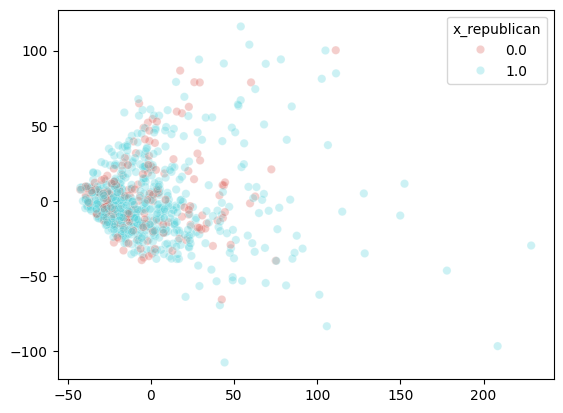

In [15]:
#%% PCA Viz

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# visualize X and X_compressed
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=Y,
    palette=sns.color_palette("hls", len(set(Y))), alpha=0.3)

plt.show()

[0.4460792  0.09376323 0.07777867]


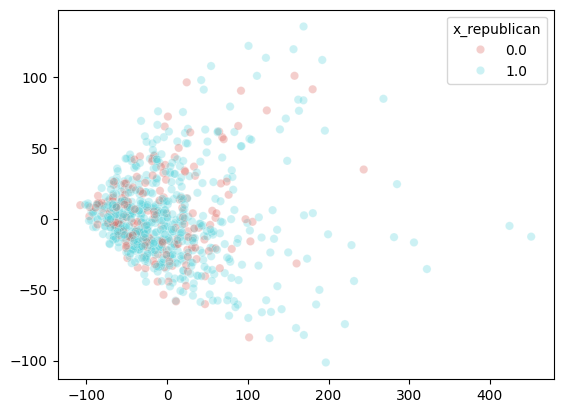

In [16]:
# visualize X and X_compressed
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X_compressed.detach().numpy())
print(pca.explained_variance_ratio_)


sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=Y,
    palette=sns.color_palette("hls", len(set(Y))), alpha=0.3)
plt.show()

# Doc Embeddings

In [17]:
from google.colab import files
uploaded_2 = files.upload()

Saving death-penalty-cases.csv to death-penalty-cases.csv


In [ ]:
###
# Setup
###
import numpy as np
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

import spacy
nlp = spacy.load('en_core_web_sm')

# word2vec requires sentences as input
sentences = []
for doc in df1['snippet']:
    sents = [sent for sent in nlp(doc).sents]
    sentences += sents
#     sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

In [ ]:
df1

,court_id,author_id,state,year,dateFiled,citeCount,snippet
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti..."
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...
...,...,...,...,...,...,...,...
32562,ohioctapp,8055.0,OH,2017,2017-07-20T00:00:00Z,0,of two counts of aggravated murder with deat...
32563,cal,NaN,CA,2017,2017-07-20T00:00:00Z,0,his general views about the death penalty as ...
32564,neb,NaN,NE,2017,2017-07-21T00:00:00Z,0,"been subject to the death\npenalty, because Ne..."
32565,ohio,5374.0,OH,2017,2017-07-25T00:00:00Z,0,that Indiana law permits imposition of the de...


**Average word2vec Embeddings**

In [18]:
from google.colab import files
uploaded_3 = files.upload()

Saving w2v-vectors.pkl to w2v-vectors.pkl


In [ ]:
###
# Make document vectors by averaging word embeddings in a document
##

# Continuous bag-of-words representation
from gensim.models import Word2Vec
w2v = Word2Vec.load('w2v-vectors.pkl')

sentvecs = []
for sentence in sentences:
    vecs = [w2v.wv[w.text] for w in sentence if w.text in w2v.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
sentvecs[0][0][:30]

array([ 3.30316345e-03, -2.47354824e-02, -1.15030892e-02,  4.12587542e-03,
       -8.11811909e-03,  1.13307377e-02,  4.66763694e-03, -8.70454684e-03,
       -1.70564242e-02,  1.84026137e-02, -2.74116676e-02,  2.27460917e-02,
       -1.89689156e-02, -1.33659607e-02,  1.49128707e-02, -1.50862876e-02,
        8.37092567e-03, -3.20090476e-05, -7.17185298e-03, -7.74981407e-03,
        4.26161177e-02,  8.50008335e-03,  1.43681085e-02,  7.84434844e-03,
       -2.80539114e-02,  4.13021492e-03, -9.98228882e-03,  1.87677331e-02,
        1.56605840e-02,  1.63804833e-02], dtype=float32)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentvecs[0],
                  sentvecs[1])[0][0]

-0.03780031

**Doc2Vec**

In [ ]:
###
# Doc2Vec
###
import nltk
nltk.download('punkt')
from nltk import word_tokenize
docs = []

for i, row in df1.iterrows():
    docs += [word_tokenize(row['snippet'])]
shuffle(docs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
doc_iterator = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(doc_iterator,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4,
                negative=5,
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size

In [ ]:
d2v.save('d2v-vectors.pkl')
files.download('d2v-vectors.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# matrix of all document vectors:
D = d2v.dv.vectors
D.shape

(32567, 100)

In [ ]:
D

array([[-0.01442758,  0.00161128, -0.0114257 , ..., -0.02385009,
         0.01441331,  0.00264662],
       [-0.05596079,  0.0332776 , -0.00617528, ..., -0.03644115,
         0.01083541,  0.03479271],
       [-0.06780909,  0.02367152,  0.00964097, ..., -0.03535675,
         0.0195537 ,  0.01944396],
       ...,
       [-0.03345212,  0.00554929,  0.00397666, ..., -0.01078317,
         0.01754208, -0.00019906],
       [-0.03025562,  0.03985487, -0.02056723, ..., -0.00357154,
         0.00728583, -0.00333761],
       [ 0.01650992,  0.00546239, -0.01284328, ...,  0.00668655,
         0.01347597, -0.0098237 ]], dtype=float32)

In [ ]:
# infer vectors for new documents
a = d2v.infer_vector(['the judge on the court'])

b = d2v.infer_vector(['the jury and the judge'])

c = d2v.infer_vector(['cats hunt mice'])

In [ ]:
a.shape, b.shape
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(b, axis=0)))
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(c, axis=0)))


[[0.1415399]]
[[0.01010424]]


In [ ]:
# get all pair-wise document similarities
pairwise_sims = cosine_similarity(D)
pairwise_sims.shape

(32567, 32567)

In [ ]:
pairwise_sims[:3,:3]

array([[1.0000002 , 0.12306896, 0.2089245 ],
       [0.12306896, 1.0000001 , 0.9390062 ],
       [0.2089245 , 0.9390062 , 1.0000002 ]], dtype=float32)

In [ ]:
# Document clusters
from sklearn.cluster import KMeans

# create 50 clusters of similar documents
num_clusters = 50
kmw = KMeans(n_clusters=num_clusters)
kmw.fit(D)

KMeans(n_clusters=50)

In [ ]:
# Documents from an example cluster
for i, doc in enumerate(docs):
    if kmw.labels_[i] == 25:
        print(' '.join(doc[:9]))
    if i == 1000:
        break

considered the Anti-Terrorism and Effective Death Penalty Act ,
mentally retarded offenders are deserving of the death penalty
imposed by the Antiterrorism and Effective Death Penalty Act
Evidence and the Propriety of the Penalty in Death
qualified venire persons with scruples against the death penalty
) & quot ; ) of the Antiterrorism and
the death penalty , or would you require convincing
E.D.Mo . ) . The Antiterrorism and Effective Death
case , in which the defendant was given the
Illinois is four times more likely to receive the
the death penalty : { ¶ } “ Q
pursuant to the Antiterrorism & amp ; amp ;
, N.E . d , ( ) . Where
Timeliness The Antiterrorism and Effective Death Penalty Act (
Section ( d ) of the Antiterrorism and Effective
a judgment of death imposed under the death penalty
petitions under the Antiterrorism and Effective Death Penalty Act
amended by the Antiterrorism and Effective Death Penalty Act
whether the defendant was eligible for the death penalty
April , , the A

In [ ]:
# t-SNE for visualization
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
# d2v_tsne = tsne.fit_transform(D)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(D)
pca.explained_variance_ratio_

array([0.48483333, 0.06831944, 0.0507626 ], dtype=float32)

In [ ]:
#vdf = pd.DataFrame(Xpca,
#                  columns=['x-tsne', 'y-tsne'])
#vdf['cluster'] = kmw.labels_

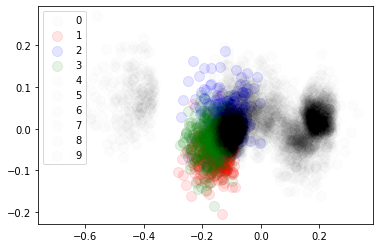

In [ ]:
#%% PCA Viz
import matplotlib.pyplot as plt

#plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)

cdict = {1: 'red', 2: 'blue', 3: 'green'}
fig, ax = plt.subplots()
#for g, label in cdict.items():
for g in np.unique(kmw.labels_):
    ix = np.where(kmw.labels_ == g)
    #ix = np.where(kmw == g)
    #    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
    if g in cdict:
        # use color from cdict
        color = cdict[g]
        ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.1)
    else:
        if g < 10:
            color = "black"
            ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.01)



ax.legend()
plt.show()

In [ ]:
# sample 100 texts to show different document embeddings techniques

texts = df1["snippet"][:100]
text = texts[0]
text, texts

('N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PENALTY.\nThe Supreme Court of New Jersey.\nSeptember & ; and County Court Judges\n\nRe: Waiver of the Death Penalty\n*  The Supreme Court is concerned by the excessive& ;cases where the prosecutor is not seeking the death penalty. It is cognizant of the fact that this situation& ;Although the prosecutor had a right to waive the death penalty and so inform the jury, the jury nevertheless& ;would assume, as did the prosecutor, that the death penalty would not be returned as it was not asked for',
 0     N.J.   ( )\n  A. d  \nIN RE WAIVER OF DEATH PE...
 1     whether the death penalty is, per se, unconsti...
 2     # ;s contention that the assessment of the dea...
 3     . d   ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
 4     assume the district attorney orally waived the...
                             ...                        
 95    guilty as to all defendants and imposing the d...
 96     present death penalty statutes, juries could .

**Other types of Document Embeddings**

In [ ]:
# spacy embeddings (= averaged gloVe embeddings)

import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp(text)
doc.vector

array([ 0.07259463, -0.34164575, -0.06046916,  0.0886262 , -0.18062969,
        0.25809065,  0.18952237,  0.24228807,  0.15163848,  0.3648723 ,
        0.16476998,  0.31935504, -0.33742335, -0.23372664, -0.25504193,
       -0.1427638 , -0.13117744,  0.17390706,  0.12673132, -0.08445496,
        0.05437264,  0.19286314,  0.24493328, -0.2609959 ,  0.11248417,
        0.10668278,  0.37426525,  0.17115824,  0.3093613 ,  0.04425178,
       -0.0233187 , -0.10240076,  0.3570475 , -0.05570314,  0.2500611 ,
       -0.2901273 ,  0.31774724, -0.15311354, -0.24933708, -0.06272297,
       -0.2067772 ,  0.11205074, -0.05756066, -0.03028489,  0.04331766,
        0.00313155, -0.09692293,  0.16776772, -0.05537047,  0.00104976,
       -0.40755585,  0.06078456,  0.02829786, -0.04705429,  0.05579825,
       -0.14171392,  0.04290417,  0.00847582,  0.4886369 , -0.10091366,
       -0.02439285, -0.2800004 ,  0.04624833, -0.17692727,  0.11192604,
        0.078035  ,  0.03098522, -0.24365486,  0.25583416, -0.03

**SBERT**

Let's choose a top model from SBERT: https://www.sbert.net/docs/pretrained_models.html

In [19]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [20]:
from sentence_transformers import SentenceTransformer
model = "all-mpnet-base-v2"
embedder = SentenceTransformer(model)
text_encoded = embedder.encode([text])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Similar to other embedding method, this embedded vector can be used to compute semantic semilarity etc.

In [23]:
text_encoded

array([[-3.93527560e-02,  3.25619876e-02,  5.90300597e-02,
        -5.55941742e-03, -3.88388373e-02,  1.32978279e-02,
         6.66806474e-02, -3.23416665e-02,  2.34209299e-02,
        -9.02550202e-03, -2.48978492e-02,  4.73650247e-02,
         4.81043535e-04, -7.76813179e-02, -1.76588185e-02,
         2.72893589e-02, -1.73093621e-02,  3.50894928e-02,
        -2.92714871e-02,  9.97750927e-03, -3.01518608e-02,
        -1.65796280e-02,  5.61909657e-03,  1.19169159e-02,
        -6.12749271e-02, -7.11845979e-02,  1.23000285e-02,
         1.44162616e-02, -1.42301926e-02,  2.22551711e-02,
        -3.77013944e-02,  2.42488664e-02,  2.18617301e-02,
        -3.02534401e-02,  2.18373339e-06, -3.87300253e-02,
        -2.25984113e-04,  1.86924473e-03,  3.07951979e-02,
        -4.27461825e-02,  1.00365123e-02, -4.13507447e-02,
         8.00417922e-03,  1.84299853e-02, -1.08989161e-02,
         2.41648778e-02, -2.52721012e-02, -7.71948835e-04,
         2.77147605e-03,  4.17933613e-02,  1.42023060e-0